**Imports**

In [1]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import splitfolders
import matplotlib.pyplot as plt
import numpy as np

**Input Data**

In [2]:
input_folder = "data_pan"

splitfolders.ratio(input_folder, output='test_train_split', seed=42, ratio=(.7, .2, .1),group_prefix=None)

Copying files: 1411 files [00:01, 736.96 files/s]


**Defining model**

In [3]:
SIZE = 150
# 2 conv and pool layers. with some normalization and drops in between.

INPUT_SHAPE = (SIZE, SIZE, 3)  # change to (SIZE, SIZE, 3)

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE,padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 73, 73, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

**Data Augmentation**

In [5]:
batch_size = 16

* Train data

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

* Validation data

In [7]:
validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
)

In [8]:
train_generator = train_datagen.flow_from_directory(
    "./test_train_split/train", 
    target_size=(150, 150),  
    batch_size=batch_size,
    class_mode="binary",
)  # since we use binary_crossentropy loss, we need binary labels


Found 987 images belonging to 2 classes.


In [9]:
validation_generator = validation_datagen.flow_from_directory(
    "./test_train_split/val",
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode="binary",
)

Found 282 images belonging to 2 classes.


**Training Checkpoints**

In [10]:
filepath = "saved_models/weights-improvement.hdf5"
es=EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=5,verbose=1,mode='auto')
checkpoint = ModelCheckpoint(
    filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"
)
callbacks_list = [checkpoint,es]

* Training

In [11]:
hs = model.fit_generator(
    train_generator,
    steps_per_epoch=16,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=16,
    callbacks=callbacks_list,
)

C:\Users\dkvhe\AppData\Local\Temp\ipykernel_7928\3872973094.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hs = model.fit_generator(


Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.7276 - accuracy: 0.8320
Epoch 1: val_accuracy improved from -inf to 0.98047, saving model to saved_models\weights-improvement.hdf5
16/16 [==============================] - 8s 446ms/step - loss: 0.7276 - accuracy: 0.8320 - val_loss: 0.1053 - val_accuracy: 0.9805
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 0.2282 - accuracy: 0.9297
Epoch 2: val_accuracy improved from 0.98047 to 0.98438, saving model to saved_models\weights-improvement.hdf5
16/16 [==============================] - 6s 373ms/step - loss: 0.2282 - accuracy: 0.9297 - val_loss: 0.0830 - val_accuracy: 0.9844
Epoch 3/30
16/16 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.9258
Epoch 3: val_accuracy did not improve from 0.98438
16/16 [==============================] - 6s 375ms/step - loss: 0.2782 - accuracy: 0.9258 - val_loss: 0.1152 - val_accuracy: 0.9805
Epoch 4/30
16/16 [==============================] - ETA: 

* Saving trained model

In [12]:
model.save("pancreatic_tumor_model.h5")
h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

* Accuracy over time

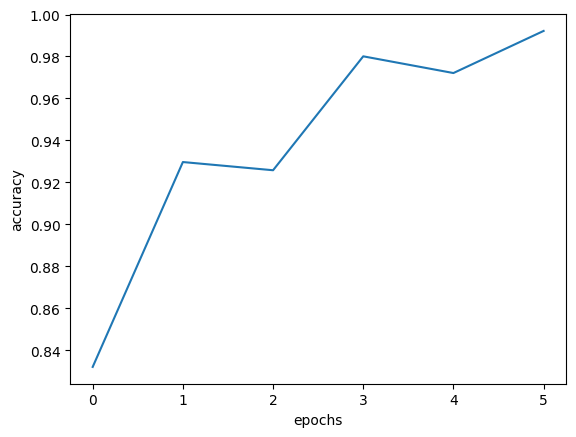

In [13]:
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.plot(h["accuracy"])

* Loss over time

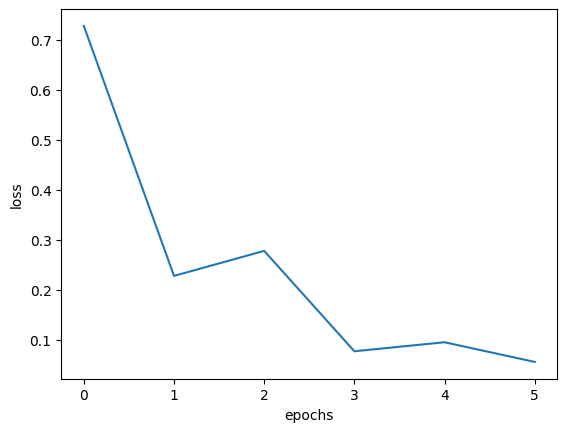

In [14]:
plt.ylabel('loss')
plt.xlabel('epochs')
plt.plot(h["loss"])

**Testing**

* Test data augmentation

In [15]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [16]:
test_generator = test_datagen.flow_from_directory(
    './test_train_split/test',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

Found 142 images belonging to 2 classes.


* Loading the saved model

In [17]:
from keras.models import load_model
model=load_model("./pancreatic_tumor_model.h5")

* Accuracy of the model

In [18]:
#Model Accuracy
acc=model.evaluate_generator(test_generator)[1]
print("Accuracy of our model is", acc)

C:\Users\dkvhe\AppData\Local\Temp\ipykernel_7928\1876032302.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc=model.evaluate_generator(test_generator)[1]


Accuracy of our model is 0.98591548204422


C:\Users\dkvhe\AppData\Local\Temp\ipykernel_7928\2358588086.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion Matrix


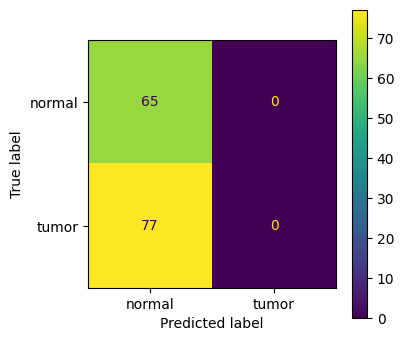

Classification Report
              precision    recall  f1-score   support

      normal       0.46      1.00      0.63        65
       tumor       0.00      0.00      0.00        77

    accuracy                           0.46       142
   macro avg       0.23      0.50      0.31       142
weighted avg       0.21      0.46      0.29       142



c:\Users\dkvhe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dkvhe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dkvhe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [19]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
# print(confusion_matrix(test_generator.classes, y_pred))

target_names = ['normal', 'tumor']
cm = confusion_matrix(test_generator.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax)
# disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


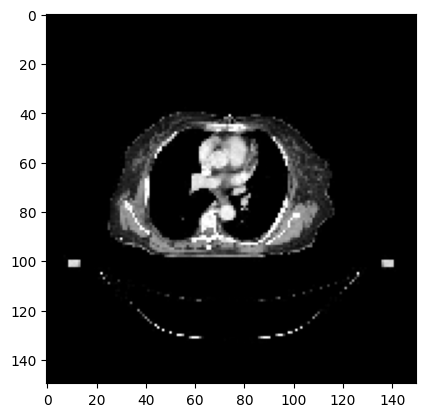

1/1 [==============================] - 0s 115ms/step
The image is having a Tumor


In [20]:
path="./DCM/jpg/3_51.jpg"
img=load_img(path,target_size=(150,150))
input_arr=img_to_array(img)/225
plt.imshow(input_arr)
plt.show()
input_arr=np.expand_dims(input_arr,axis=0)
pred=(model.predict(input_arr) > 0.5).astype("int32")
if(pred==0):
  print("The image is normal")
else:
  print("The image is having a Tumor")